# KPMG Virtual Internship

# Task 2: Data Insights

### ---- 1 Background ----

Sprocket Central Pty Ltd has given us a new list of 1000 potential customers with their demographics and attributes. These customers do not have prior transaction history with the organisation. 

Clients wants to identify high value customers to target for marketing. 

### ---- 2 Task ----

**Using the existing 3 datasets (Customer demographic, customer address and transactions) as a labelled dataset, recommend which of these 1000 new customers should be targeted.**

In [1]:
#import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn as sk
import seaborn as sns
from sklearn.impute import SimpleImputer
import datetime

#my info
__author__ = 'Cici Du'
__email__ = 'cicidhz@gmail.com'

### ---- 3 Load the data ----

In [2]:
transactions_df = pd.read_csv('../data/interim/transactions_df.csv')
custdemo_df = pd.read_csv ('../data/interim/custdemo_df.csv')
custaddress_df = pd.read_csv('../data/interim/custaddress_df.csv')
newcustomer_df = pd.read_excel('../data/KPMG_VI_Raw_Data.xlsx', sheet_name = 'NewCustomerList', skiprows = 1)

/var/folders/bg/7gtqbmv57q18_39nvwb8mgb80000gn/T/ipykernel_3585/418929900.py:4: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  newcustomer_df = pd.read_excel('../data/KPMG_VI_Raw_Data.xlsx', sheet_name = 'NewCustomerList', skiprows = 1)


In [3]:
newcustomer_df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.89,0.8900,1.1125,0.945625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,1.01,1.0100,1.0100,1.010000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.87,1.0875,1.0875,1.087500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.52,0.5200,0.6500,0.650000,4,4,1.703125


In [4]:
newcustomer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   object        
 3   past_3_years_bike_related_purchases  1000 non-null   int64         
 4   DOB                                  983 non-null    datetime64[ns]
 5   job_title                            894 non-null    object        
 6   job_industry_category                835 non-null    object        
 7   wealth_segment                       1000 non-null   object        
 8   deceased_indicator                   1000 non-null   object        
 9   owns_car                             1000 non-null   object        
 10  tenure       

In [5]:
newcustomer_df.duplicated().sum()

0

In [6]:
newcustomer_df['gender'].unique()

array(['Male', 'Female', 'U'], dtype=object)

In [7]:
(newcustomer_df['gender']=='U').sum()

17

In [8]:
newcustomer_df['state'].unique()

array(['QLD', 'NSW', 'VIC'], dtype=object)

Notes on the new customer table: <br>
* Gender value "U" needs to be imputed.
* Missing data in multiple columns. 

### ---- 4 Clean the data ----

#### Transactions table

In [9]:
transactions_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2012-12-02
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-03
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,1999-07-20
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,1998-12-16
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,2015-08-10


In [10]:
transactions_df.order_status.value_counts()

Approved     19821
Cancelled      179
Name: order_status, dtype: int64

In [11]:
#drop records where order_status == 'Cancelled'
cl_transactions_df = transactions_df[transactions_df.order_status != 'Cancelled']
cl_transactions_df.order_status.value_counts()

Approved    19821
Name: order_status, dtype: int64

In [12]:
#drop the order status column
cl_transactions_df = cl_transactions_df.drop(['order_status'], axis = 1)

In [13]:
cl_transactions_df['transaction_date'] = pd.to_datetime(cl_transactions_df.transaction_date, format='%Y-%m-%d')

In [14]:
cl_transactions_df.head(10)

,transaction_id,product_id,customer_id,transaction_date,online_order,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Solex,Standard,medium,medium,71.49,53.62,2012-12-02
1,2,3,3120,2017-05-21,1.0,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-03
2,3,37,402,2017-10-16,0.0,OHM Cycles,Standard,low,medium,1793.43,248.82,1999-07-20
3,4,88,3135,2017-08-31,0.0,Norco Bicycles,Standard,medium,medium,1198.46,381.10,1998-12-16
4,5,78,787,2017-10-01,1.0,Giant Bicycles,Standard,medium,large,1765.30,709.48,2015-08-10
5,6,25,2339,2017-03-08,1.0,Giant Bicycles,Road,medium,medium,1538.99,829.65,2006-11-10
6,7,22,1542,2017-04-21,1.0,WeareA2B,Standard,medium,medium,60.34,45.26,1993-07-15
7,8,15,2459,2017-07-15,0.0,WeareA2B,Standard,medium,medium,1292.84,13.44,2009-04-12
8,9,67,1305,2017-08-10,0.0,Solex,Standard,medium,large,1071.23,380.74,1991-08-05
9,10,12,3262,2017-08-30,1.0,WeareA2B,Standard,medium,medium,1231.15,161.60,2004-08-17


In [15]:
cl_transactions_df.to_csv('../data/interim/cleaned_transactions.csv', index=False);

#### Customer demographics table

In [16]:
custdemo_df.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,Yes,15.0
3,4,Talbot,NaN,Male,33,1961-10-03,NaN,IT,Mass Customer,N,No,7.0
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,N,Yes,8.0


In [17]:
#drop first_name, last_name
cl_custdemo_df = custdemo_df.drop(['first_name', 'last_name'], axis = 1)

In [18]:
#create an age colum. This dataset is from 2018 but we don't have an exact date
cl_custdemo_df['DOB'] = pd.to_datetime(cl_custdemo_df.DOB, format='%Y-%m-%d')
cl_custdemo_df['age'] = 2018 - cl_custdemo_df['DOB'].dt.year

In [19]:
cl_custdemo_df['age'].describe()

count    3912.000000
mean       40.935072
std        12.617249
min        16.000000
25%        31.000000
50%        41.000000
75%        50.000000
max        87.000000
Name: age, dtype: float64

In [20]:
#drop first_name, last_name, DOB and deaceased_indicator columns
cl_custdemo_df = cl_custdemo_df.drop(['DOB','deceased_indicator'], axis = 1)

In [21]:
cl_custdemo_df.to_csv('../data/interim/cleaned_custdemo.csv', index=False)

#### Customer address table

In [22]:
custaddress_df.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,NSW,Australia,10
1,2,6 Meadow Vale Court,2153,NSW,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,NSW,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [23]:
custaddress_df['country'].value_counts()

Australia    3999
Name: country, dtype: int64

In [24]:
#drop columns we will not work with
cl_custaddress_df = custaddress_df.drop(['address','country'], axis = 1)

In [25]:
cl_custaddress_df.to_csv('../data/interim/cleaned_custaddress.csv', index=False)

#### New customers table

In [26]:
newcustomer_df.head()

,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,state,country,property_valuation,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Rank,Value
0,Chickie,Brister,Male,86,1957-07-12,General Manager,Manufacturing,Mass Customer,N,Yes,...,QLD,Australia,6,0.56,0.7000,0.8750,0.743750,1,1,1.718750
1,Morly,Genery,Male,69,1970-03-22,Structural Engineer,Property,Mass Customer,N,No,...,NSW,Australia,11,0.89,0.8900,1.1125,0.945625,1,1,1.718750
2,Ardelis,Forrester,Female,10,1974-08-28,Senior Cost Accountant,Financial Services,Affluent Customer,N,No,...,VIC,Australia,5,1.01,1.0100,1.0100,1.010000,1,1,1.718750
3,Lucine,Stutt,Female,64,1979-01-28,Account Representative III,Manufacturing,Affluent Customer,N,Yes,...,QLD,Australia,1,0.87,1.0875,1.0875,1.087500,4,4,1.703125
4,Melinda,Hadlee,Female,34,1965-09-21,Financial Analyst,Financial Services,Affluent Customer,N,No,...,NSW,Australia,9,0.52,0.5200,0.6500,0.650000,4,4,1.703125


In [27]:
#drop hidden columns
cl_newcust_df = newcustomer_df.drop(newcustomer_df.columns[[16,17,18,19,20]], axis = 1)

In [28]:
cl_newcust_df.country.value_counts()

Australia    1000
Name: country, dtype: int64

In [29]:
cl_newcust_df = cl_newcust_df.drop(['first_name', 'last_name', 'country', 'Rank', 'Value'], axis = 1)

In [30]:
cl_newcust_df.gender.value_counts()

Female    513
Male      470
U          17
Name: gender, dtype: int64

In [31]:
#impute the gender value 'U' with mode
imputer = SimpleImputer(missing_values = 'U', strategy = 'most_frequent')
cl_newcust_df.gender = imputer.fit_transform(cl_newcust_df['gender'].values.reshape(-1,1))[:,0]
cl_newcust_df.gender.value_counts()

Female    530
Male      470
Name: gender, dtype: int64

In [32]:
cl_newcust_df.to_csv('../data/interim/cleaned_newcust_df.csv', index=False)

### ---- 5 Exploratory the Data  ----

Data visualization is also done in Tableau. Links to Tableau dashboards can be found in the readme file. 

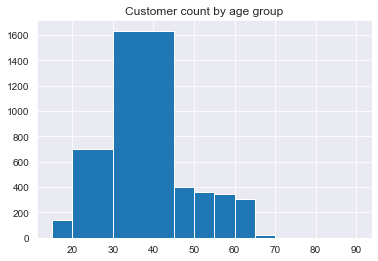

In [33]:
sns.set_style("darkgrid")
from matplotlib import cm as cm
my_colors = cm.get_cmap('tab20').colors
plt.hist(cl_custdemo_df['age'], bins=[15,20,30,45,50,55,60,65,70,75,80,85,90])
plt.title('Customer count by age group');

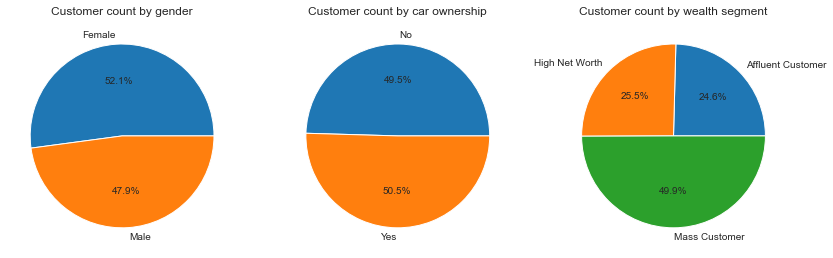

In [34]:
def plot_pie(column):
    return cl_custdemo_df.groupby(column).customer_id.count().plot.pie(autopct='%1.1f%%')

plt.figure(figsize = (14, 6))
plt.subplot(1,3,1)
plt.title("Customer count by gender")
plot_pie('gender')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Customer count by car ownership")
plot_pie('owns_car')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Customer count by wealth segment")
plot_pie('wealth_segment')
plt.axis('off');

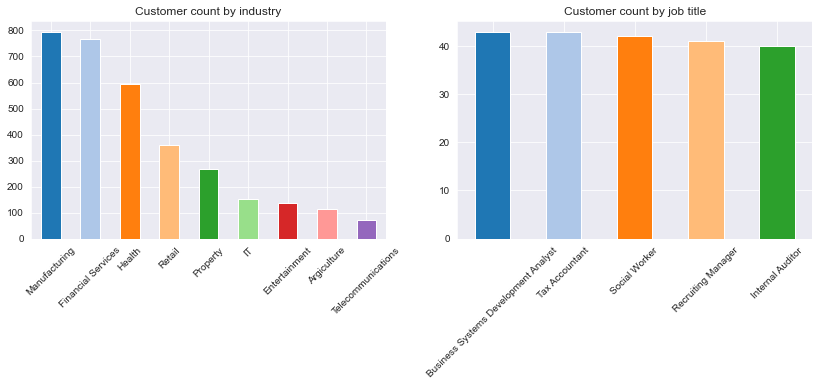

In [35]:
plt.figure(figsize = (14, 4))
plt.subplot(1,2,1)
plt.title('Customer count by industry')
cl_custdemo_df.groupby("job_industry_category").customer_id.count().sort_values(ascending=False).plot.bar(color=my_colors)
plt.xticks(rotation=45)
plt.xlabel('')

plt.subplot(1,2,2)
plt.title('Customer count by job title')
cl_custdemo_df.groupby("job_title").customer_id.count().sort_values(ascending=False)[:5].plot.bar(color=my_colors)
plt.xticks(rotation=45)
plt.xlabel('');

By exploring customer demographics, we find: 
<br>
* The majority of customers are in the age groups between 20 to 45.
* The client has slightly more female customers than male. 
* Customers who own cars are 1% more than customers who don't own cars. 
* Mass Customers make up the largest portion of the customer base in terms of wealth segment. 
* More than half of customers work in Manufacturing, Financial Services and the Health industries. 
* Top three job titles held by customers are: Tax Accountant, Business System Development Analyst, and Social Worker. 

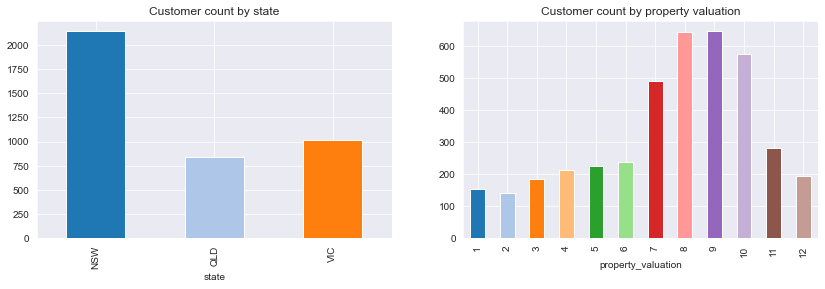

In [36]:
def plot_bar(column):
    return cl_custaddress_df.groupby(column).customer_id.count().plot.bar(color=my_colors)
plt.figure(figsize = (14,4))
plt.subplot(1,2,1)
plt.title("Customer count by state")
plot_bar('state')
plt.subplot(1,2,2)
plt.title("Customer count by property valuation")
plot_bar('property_valuation');

By exploring the customer addresses data, we find:
<br>
* Most of customers reside in the NSW region. 
* Most customers own properties valued from 6 to 11. 

### ---- 6 RFM Analysis  ----

In [37]:
cl_transactions_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,0.0,Solex,Standard,medium,medium,71.49,53.62,2012-12-02
1,2,3,3120,2017-05-21,1.0,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-03
2,3,37,402,2017-10-16,0.0,OHM Cycles,Standard,low,medium,1793.43,248.82,1999-07-20
3,4,88,3135,2017-08-31,0.0,Norco Bicycles,Standard,medium,medium,1198.46,381.10,1998-12-16
4,5,78,787,2017-10-01,1.0,Giant Bicycles,Standard,medium,large,1765.30,709.48,2015-08-10


We will use the RFM segmentation method to score and group customers based on these three criteria:
<br>
* Recency(1~4): When was the customer's last purchase?
* Frequency(1~4): How often did customer make a purchase in 2017? 
* Monetary Value(1~4): How much did the customer spend in 2017?

In [38]:
cl_transactions_df.transaction_date.describe()

/var/folders/bg/7gtqbmv57q18_39nvwb8mgb80000gn/T/ipykernel_3585/607719106.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  cl_transactions_df.transaction_date.describe()


count                   19821
unique                    364
top       2017-02-14 00:00:00
freq                       82
first     2017-01-01 00:00:00
last      2017-12-30 00:00:00
Name: transaction_date, dtype: object

In [39]:
#group by customer id
df = cl_transactions_df
rfm_score_df = df.groupby('customer_id').agg({'transaction_date': max,
                                             'transaction_id': 'count',
                                             'list_price': sum})

In [40]:
rfm_score_df.columns = ['last_transaction_date', 'no_of_purchases','total_spend']
rfm_score_df.head()

,last_transaction_date,no_of_purchases,total_spend
customer_id,,,
1,2017-12-23,11,9084.45
2,2017-08-24,3,4149.07
3,2017-09-19,8,9888.23
4,2017-06-18,2,1047.72
5,2017-12-14,6,5903.20


In [41]:
#assign RSORE
def calculate_rscore(row):
    if row['last_transaction_date'] > datetime.date(2017,9,30):
        rscore = 4
    elif datetime.date(2017,6,30) < row['last_transaction_date'] <= datetime.date(2017,9,30):
        rscore = 3
    elif datetime.date(2017,3,31) < row['last_transaction_date'] <= datetime.date(2017,6,30):
        rscore = 2
    else: 
        rscore = 1
    return rscore
rfm_score_df['rscore'] = rfm_score_df.apply(calculate_rscore, axis = 1)
rfm_score_df.head(10)

/var/folders/bg/7gtqbmv57q18_39nvwb8mgb80000gn/T/ipykernel_3585/3951519131.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if row['last_transaction_date'] > datetime.date(2017,9,30):
/var/folders/bg/7gtqbmv57q18_39nvwb8mgb80000gn/T/ipykernel_3585/3951519131.py:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  elif datetime.date(2017,6,30) < row['last_transaction_date'] <= datetime.date(2017,9,30):
/var/folders/bg/7gtqbmv57q18_39nvwb8mgb80000gn/T/ipykernel_3585/3951519131.py:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library be

,last_transaction_date,no_of_purchases,total_spend,rscore
customer_id,,,,
1,2017-12-23,11,9084.45,4
2,2017-08-24,3,4149.07,3
3,2017-09-19,8,9888.23,3
4,2017-06-18,2,1047.72,2
5,2017-12-14,6,5903.20,4
6,2017-10-27,5,5931.69,4
7,2017-04-21,3,995.38,2
8,2017-12-08,10,12024.76,4
9,2017-10-13,6,5357.55,4


In [42]:
rfm_score_df['no_of_purchases'].describe()

count    3493.000000
mean        5.674492
std         2.311440
min         1.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: no_of_purchases, dtype: float64

In [43]:
def calculate_fscore(row):
    if row['no_of_purchases'] >= 7:
        fscore = 4
    elif 6 <= row['no_of_purchases'] < 7:
        fscore = 3
    elif 4 <= row['no_of_purchases'] < 6:
        fscore = 2
    else:
        fscore = 1
    return fscore
rfm_score_df['fscore'] = rfm_score_df.apply(calculate_fscore, axis = 1)
rfm_score_df.head()

,last_transaction_date,no_of_purchases,total_spend,rscore,fscore
customer_id,,,,,
1,2017-12-23,11,9084.45,4,4
2,2017-08-24,3,4149.07,3,1
3,2017-09-19,8,9888.23,3,4
4,2017-06-18,2,1047.72,2,1
5,2017-12-14,6,5903.20,4,3


In [44]:
rfm_score_df['total_spend'].describe()

count     3493.000000
mean      6285.198022
std       2941.998917
min         60.340000
25%       4162.960000
50%       5974.770000
75%       8157.720000
max      19071.320000
Name: total_spend, dtype: float64

In [45]:
def calculate_mscore(row):
    if row['total_spend'] >= 8157.720000:
        mscore = 4
    elif 5974.770000 <= row['total_spend'] < 8157.720000:
        mscore = 3
    elif 4162.960000 <= row['total_spend'] < 5974.770000:
        mscore = 2
    else:
        mscore = 1
    return mscore
rfm_score_df['mscore'] = rfm_score_df.apply(calculate_fscore, axis = 1)
rfm_score_df.head()

,last_transaction_date,no_of_purchases,total_spend,rscore,fscore,mscore
customer_id,,,,,,
1,2017-12-23,11,9084.45,4,4,4
2,2017-08-24,3,4149.07,3,1,1
3,2017-09-19,8,9888.23,3,4,4
4,2017-06-18,2,1047.72,2,1,1
5,2017-12-14,6,5903.20,4,3,3


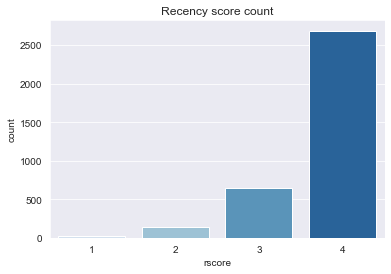

In [46]:
plt.title('Recency score count')
sns.countplot(x= 'rscore', data=rfm_score_df, palette = 'Blues');

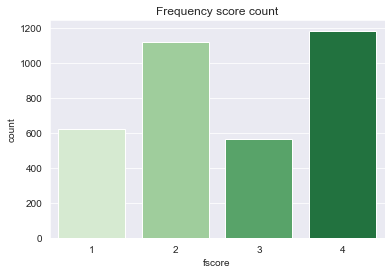

In [47]:
plt.title('Frequency score count')
sns.countplot(x= 'fscore', data=rfm_score_df, palette = 'Greens');

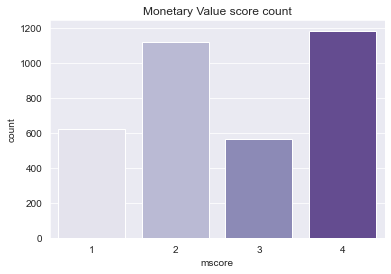

In [48]:
plt.title('Monetary Value score count')
sns.countplot(x= 'mscore', data=rfm_score_df, palette = 'Purples');

From the above plots, we see:
* Over 2500 customers made a puchase in the most recent three months. 
* Customers that made equal to or more than 7 purchases in 2017 make up the largest group in terms of frequency.  
* Categorized by monetary value, the distribution is similar to that of the fscore, with customers who spent the most making up the largest group. 

In [49]:
def generate_segment(row):
    return str(row['rscore'])+str(row['fscore'])+ str(row['mscore'])
rfm_score_df['rfm_segment_str'] = rfm_score_df.apply(generate_segment, axis = 1)
rfm_score_df.head()

,last_transaction_date,no_of_purchases,total_spend,rscore,fscore,mscore,rfm_segment_str
customer_id,,,,,,,
1,2017-12-23,11,9084.45,4,4,4,444
2,2017-08-24,3,4149.07,3,1,1,311
3,2017-09-19,8,9888.23,3,4,4,344
4,2017-06-18,2,1047.72,2,1,1,211
5,2017-12-14,6,5903.20,4,3,3,433


In [50]:
rfm_count_unique = rfm_score_df.groupby('rfm_segment_str')['rfm_segment_str'].nunique()
print(rfm_count_unique.sum())

15


In [51]:
#list each segment
rfm_score_df['rfm_segment_str'].value_counts()

444    1079
422     817
433     463
411     327
322     258
311     189
344     102
333      95
211      82
222      43
111      25
233       7
122       2
244       2
133       2
Name: rfm_segment_str, dtype: int64

To achieve our purpose of customer targeting, We will further group these segments together to establish the target group.

In [52]:
def generate_score(row):
    return row['rscore']+row['fscore']+ row['mscore']
rfm_score_df['rfm_score'] = rfm_score_df.apply(generate_score, axis = 1)
rfm_score_df.head()

,last_transaction_date,no_of_purchases,total_spend,rscore,fscore,mscore,rfm_segment_str,rfm_score
customer_id,,,,,,,,
1,2017-12-23,11,9084.45,4,4,4,444,12
2,2017-08-24,3,4149.07,3,1,1,311,5
3,2017-09-19,8,9888.23,3,4,4,344,11
4,2017-06-18,2,1047.72,2,1,1,211,4
5,2017-12-14,6,5903.20,4,3,3,433,10


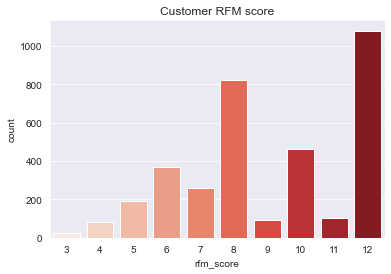

In [53]:
sns.countplot(x= 'rfm_score', data=rfm_score_df, palette = 'Reds')
plt.title('Customer RFM score');

In [54]:
rfm_score_df['rfm_score'].describe()

count    3493.000000
mean        9.036645
std         2.497382
min         3.000000
25%         7.000000
50%         8.000000
75%        12.000000
max        12.000000
Name: rfm_score, dtype: float64

Based on the RFM scoring, we identified over 1000 customers as best customers, making up the largest customer group.<br>
The second largest group of customers scored 8, which is also the median score. 

In [55]:
def label_customer(row):
    if row['rfm_segment_str'] == '444':
        label = 'best'
    elif 9 <= row['rfm_score'] < 12:
        label = 'high potential'
    else:
        label = None
    return label
rfm_score_df['rfm_label'] = rfm_score_df.apply(label_customer, axis = 1)

In [56]:
rfm_score_df['rfm_label'].value_counts()

best              1079
high potential     662
Name: rfm_label, dtype: int64

In [57]:
#create the target variable
def generate_target(row):
    if row['rfm_label'] == 'best' or row['rfm_label'] == 'high potential':
        target = 1
    else:
        target = 0
    return target
rfm_score_df['target'] = rfm_score_df.apply(generate_target, axis = 1)
rfm_score_df.head(10)

,last_transaction_date,no_of_purchases,total_spend,rscore,fscore,mscore,rfm_segment_str,rfm_score,rfm_label,target
customer_id,,,,,,,,,,
1,2017-12-23,11,9084.45,4,4,4,444,12,best,1
2,2017-08-24,3,4149.07,3,1,1,311,5,None,0
3,2017-09-19,8,9888.23,3,4,4,344,11,high potential,1
4,2017-06-18,2,1047.72,2,1,1,211,4,None,0
5,2017-12-14,6,5903.20,4,3,3,433,10,high potential,1
6,2017-10-27,5,5931.69,4,2,2,422,8,None,0
7,2017-04-21,3,995.38,2,1,1,211,4,None,0
8,2017-12-08,10,12024.76,4,4,4,444,12,best,1
9,2017-10-13,6,5357.55,4,3,3,433,10,high potential,1


In [58]:
rfm_target_df = rfm_score_df.filter(['customer id','target'], axis=1)
rfm_target_df.head()

,target
customer_id,
1,1
2,0
3,1
4,0
5,1


In [59]:
rfm_score_df.to_csv('rfm_score.csv')
rfm_target_df.to_csv('rfm_target.csv')

#### Prepare the final dataset for model development

In [60]:
cl_custdemo_df.head()

,customer_id,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,owns_car,tenure,age
0,1,Female,93,Executive Secretary,Health,Mass Customer,Yes,11.0,65
1,2,Male,81,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,38
2,3,Male,61,Recruiting Manager,Property,Mass Customer,Yes,15.0,64
3,4,Male,33,NaN,IT,Mass Customer,No,7.0,57
4,5,Female,56,Senior Editor,NaN,Affluent Customer,Yes,8.0,41


In [61]:
cl_custaddress_df.head()

,customer_id,postcode,state,property_valuation
0,1,2016,NSW,10
1,2,2153,NSW,10
2,4,4211,QLD,9
3,5,2448,NSW,4
4,6,3216,VIC,9


In [62]:
merged_df = pd.merge(cl_custdemo_df, cl_custaddress_df, on = 'customer_id')
merged_df.head()

,customer_id,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,owns_car,tenure,age,postcode,state,property_valuation
0,1,Female,93,Executive Secretary,Health,Mass Customer,Yes,11.0,65,2016,NSW,10
1,2,Male,81,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,38,2153,NSW,10
2,4,Male,33,NaN,IT,Mass Customer,No,7.0,57,4211,QLD,9
3,5,Female,56,Senior Editor,NaN,Affluent Customer,Yes,8.0,41,2448,NSW,4
4,6,Male,35,NaN,Retail,High Net Worth,Yes,13.0,52,3216,VIC,9


In [63]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3908 entries, 0 to 3907
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3908 non-null   int64  
 1   gender                               3908 non-null   object 
 2   past_3_years_bike_related_purchases  3908 non-null   int64  
 3   job_title                            3413 non-null   object 
 4   job_industry_category                3253 non-null   object 
 5   wealth_segment                       3908 non-null   object 
 6   owns_car                             3908 non-null   object 
 7   tenure                               3908 non-null   float64
 8   age                                  3908 non-null   int64  
 9   postcode                             3908 non-null   int64  
 10  state                                3908 non-null   object 
 11  property_valuation            

In [64]:
#merge with the target variable
merged_df = pd.merge(merged_df, rfm_target_df, on = 'customer_id')
merged_df.head()

,customer_id,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,owns_car,tenure,age,postcode,state,property_valuation,target
0,1,Female,93,Executive Secretary,Health,Mass Customer,Yes,11.0,65,2016,NSW,10,1
1,2,Male,81,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,38,2153,NSW,10,0
2,4,Male,33,NaN,IT,Mass Customer,No,7.0,57,4211,QLD,9,0
3,5,Female,56,Senior Editor,NaN,Affluent Customer,Yes,8.0,41,2448,NSW,4,1
4,6,Male,35,NaN,Retail,High Net Worth,Yes,13.0,52,3216,VIC,9,0


In [65]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3411 entries, 0 to 3410
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3411 non-null   int64  
 1   gender                               3411 non-null   object 
 2   past_3_years_bike_related_purchases  3411 non-null   int64  
 3   job_title                            2996 non-null   object 
 4   job_industry_category                2851 non-null   object 
 5   wealth_segment                       3411 non-null   object 
 6   owns_car                             3411 non-null   object 
 7   tenure                               3411 non-null   float64
 8   age                                  3411 non-null   int64  
 9   postcode                             3411 non-null   int64  
 10  state                                3411 non-null   object 
 11  property_valuation            

In [66]:
merged_df.to_csv('../data/interim/merged_df.csv', index = False)